In [1]:
import sklearn
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

In [5]:
np.random.seed(42)

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

warnings.filterwarnings(action="ignore", message="^internal gelsd")

HOUSING_PATH = "housing.csv"

In [9]:
housing = pd.read_csv(HOUSING_PATH)

# Drop any rows with missing values
housing.dropna(inplace=True)

housing.reset_index(drop=True, inplace=True)

# Divide the median income attribute into bins and labels
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"]

0        5
1        5
2        5
3        4
4        3
        ..
20428    2
20429    2
20430    2
20431    2
20432    2
Name: income_cat, Length: 20433, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Drop the "income_cat" column from both train and test sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
# Create a copy of the strat_train_set dataset and save it in the housing variable
housing = strat_train_set.copy()

# Create new features
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

# Define the indices of columns
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [12]:
# Apply the custom transformer on the housing dataset
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [13]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Create housing_extra_attribs DataFrame
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index)

In [14]:
# Define the numerical attributes and categorical attributes
num_attribs = list(housing.select_dtypes(include=[np.number]))
cat_attribs = ["ocean_proximity"]

In [15]:
# Create the numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Create the full pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])


In [18]:
# Fit and transform the entire training data
housing_prepared = full_pipeline.fit_transform(housing)

In [19]:
# Train the DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing["median_house_value"])


DecisionTreeRegressor(random_state=42)

In [20]:
# Train the RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=30, random_state=42)
forest_reg.fit(housing_prepared, housing["median_house_value"])

RandomForestRegressor(n_estimators=30, random_state=42)

In [21]:
# Define the display_scores function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [22]:
# Calculate cross validation scores for the Decision Tree model
scores = cross_val_score(tree_reg, housing_prepared, housing["median_house_value"],
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [281.61830502  82.46952917  95.14193485 102.32765028  98.21028428
 144.74484774  97.45852459 119.96276707 104.1077965  115.29325071]
Mean: 124.1334890227552
Standard deviation: 54.91659595589574


In [23]:
# Calculate cross validation scores for the Random Forest model
forest_scores = cross_val_score(forest_reg, housing_prepared, housing["median_house_value"],
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [203.01019652  55.03873779  79.26165487  87.36476171  59.85715928
 159.39506596  50.74881143  68.8699459   63.52752338  84.55252573]
Mean: 91.16263825629616
Standard deviation: 47.480734667548994


In [24]:
# Define the hyperparameter grid
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [25]:
# Create the RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing["median_house_value"])


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
# Display the best combination of parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Display the best estimator
print("Best Estimator:", grid_search.best_estimator_)

Best Hyperparameters: {'max_features': 8, 'n_estimators': 30}
Best Estimator: RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [27]:
# Compute and print the results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Set the best estimator from GridSearchCV as the final model
final_model = grid_search.best_estimator_

35382.066379083684 {'max_features': 2, 'n_estimators': 3}
27425.25544771895 {'max_features': 2, 'n_estimators': 10}
26550.893417144245 {'max_features': 2, 'n_estimators': 30}
18376.399259822447 {'max_features': 4, 'n_estimators': 3}
15231.647473914869 {'max_features': 4, 'n_estimators': 10}
13851.584732135092 {'max_features': 4, 'n_estimators': 30}
13205.320866813392 {'max_features': 6, 'n_estimators': 3}
9800.591977418077 {'max_features': 6, 'n_estimators': 10}
8305.874865952479 {'max_features': 6, 'n_estimators': 30}
6513.13782327185 {'max_features': 8, 'n_estimators': 3}
5011.214681487371 {'max_features': 8, 'n_estimators': 10}
4266.466107592006 {'max_features': 8, 'n_estimators': 30}
31401.142879812607 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
25320.28961448655 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
25263.70584893881 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
20407.55996509387 {'bootstrap': False, 'max_features': 3, 'n_estimator

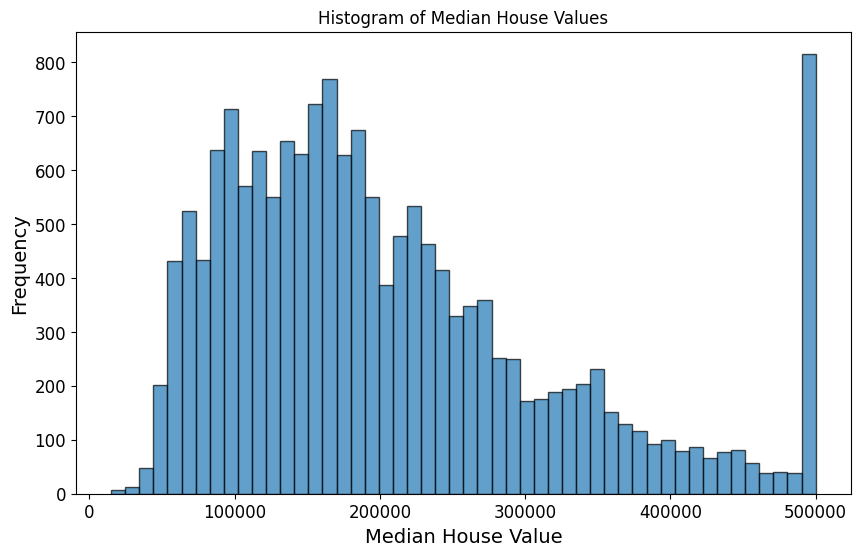

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(housing["median_house_value"], bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.title('Histogram of Median House Values')
plt.show()


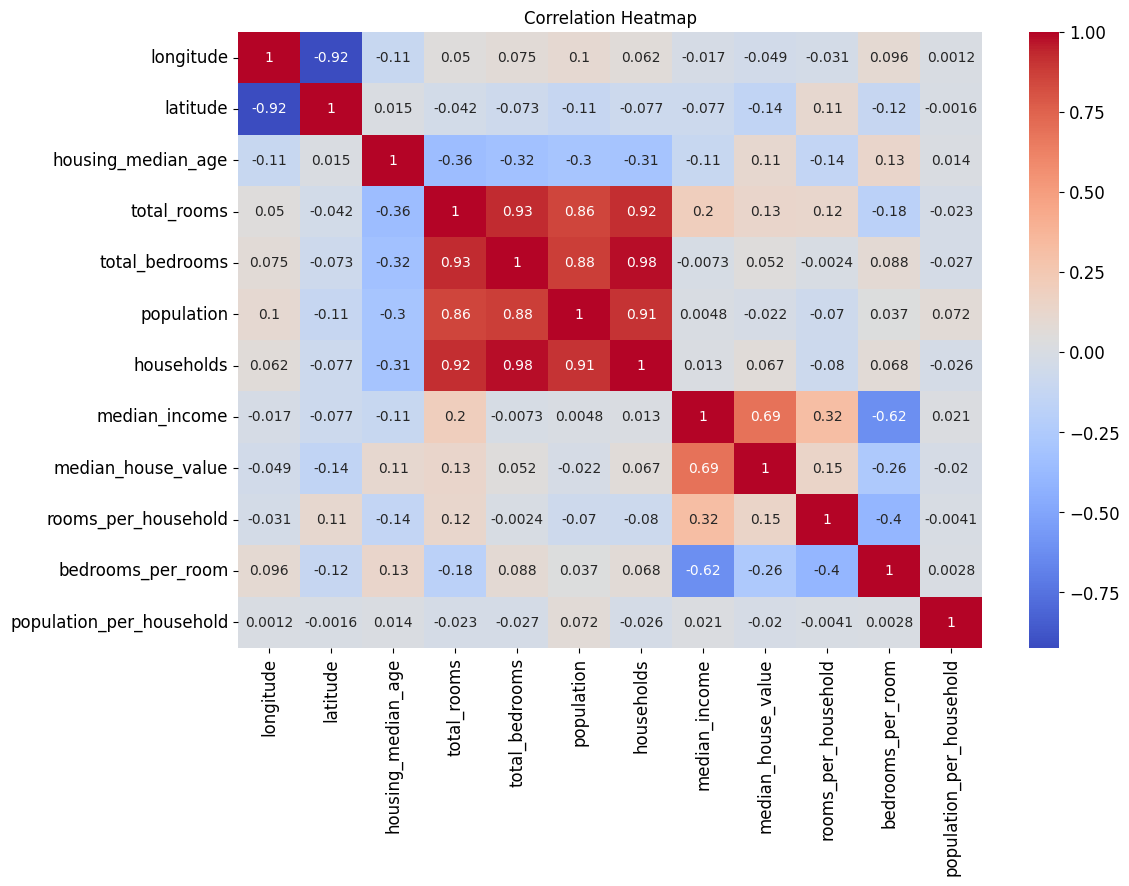

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Import Seaborn for visualization

# Exclude non-numeric columns from the DataFrame
numeric_housing = housing.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_housing.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()


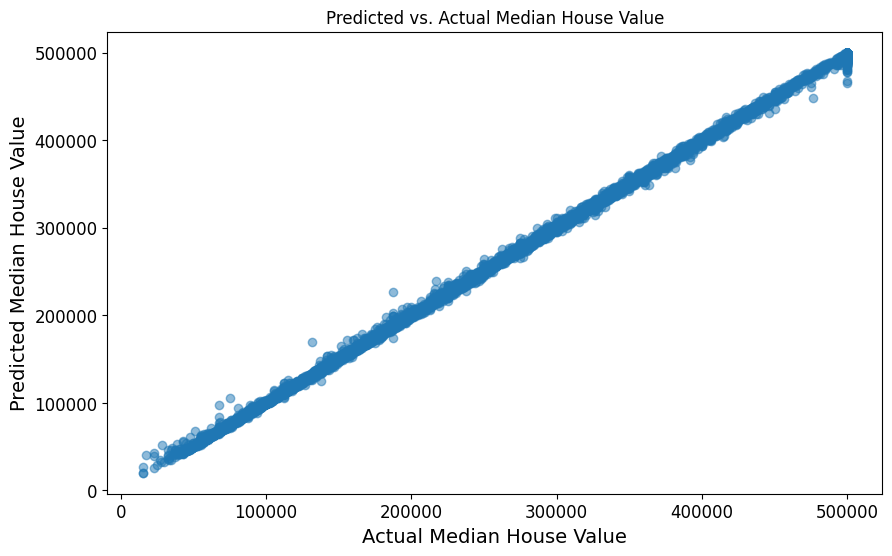

In [41]:
# Make predictions using the final model
final_predictions = final_model.predict(housing_prepared)

plt.figure(figsize=(10, 6))
plt.scatter(housing["median_house_value"], final_predictions, alpha=0.5)
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Predicted vs. Actual Median House Value')
plt.show()
